<p>
<center>
<sup><strong>
<h1>
Analysis of SEM Images of Steel
</h1>
</strong></sup>
</center>
</p>

<p>
<ul>

<li style="float: left; display: inline">
<a href="https://travis-ci.org/wd15/sem-image-stats" target="_blank">
<img src="https://api.travis-ci.org/wd15/sem-image-stats.svg"
alt="Travis CI">
</a>
</li>

<li style="float: left; display: inline">
<a href="https://github.com/wd15/sem-images-stats/blob/master/LICENSE.md" target="_blank">
<img src="https://img.shields.io/badge/license-mit-blue.svg"
alt="Travis CI">
</a>
</li>

</ul>
</p>
<br>

### Overview

The goal of this work is to analyze images of steel from SEM. The initial data set consists of 9 images. The first step in the work (comprising this notebook) is to categorize the microstructure in each image. A number of analysis steps are required including

 - extracting metadata embedded in the image,
 - cropping the images,
 - extracting meta-data from the images,
 - thresholding the images to increase contrast,
 - classifying the pixels in the image as a given phase,
 - classifying the inter lammelar spacing in one of the phases.

### Git LFS

The image files are stored in Git using Git-LFS. This is an exploratory attempt at using Git-LFS. Future work with very large volumes of data will require a public server with Git-LFS deployed as the current work uses GitHub, which only allows 2GB of data storage.

### Toolz

This analysis uses [Toolz](http://toolz.readthedocs.io/en/latest/) to explore the use of functional programming for data pipelines in Python. It seems to make the code a lot cleaner with less intermediate variables, which seems to be an advantage especially when evaluating cells in the notebook. Overall, it is currently unclear how much of benefit this approach provides. It does seem to obfuscate some of the code for non-functional programmers. Hopefully, it will help with parallel processing of the data pipelines using Dask in the future.

### Reproducible

The notebook is tested on Travis CI so the computational environment can be built by following the steps in `.travis.yml`.

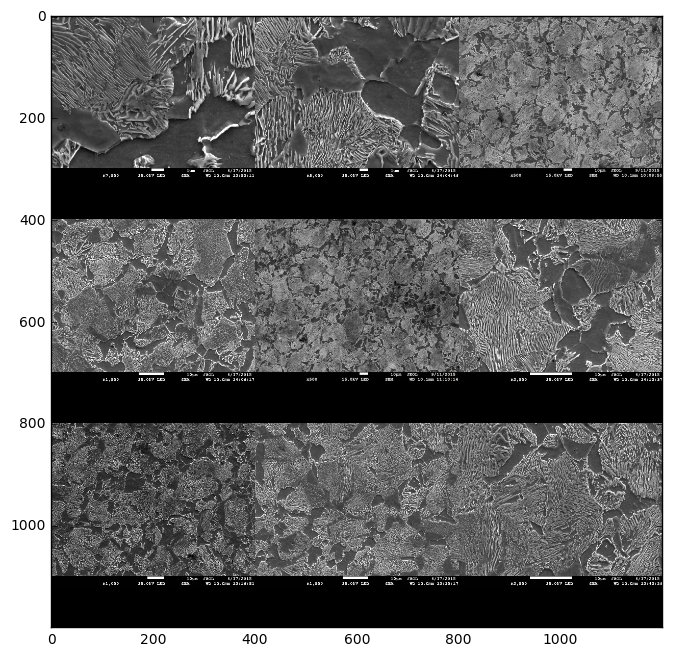

In [42]:
%matplotlib inline

import glob
from PIL import Image
from matplotlib.pyplot import imshow
import numpy as np
import matplotlib.pyplot as plt

filenames = glob.glob("data/*.tif")

images = [Image.open(filename) for filename in filenames]
#creates a new empty image, RGB mode, and size 400 by 400.
new_im = Image.new('RGB', (1200 , 1200))

#Here I resize my opened image, so it is no bigger than 100,100

#Iterate through a 4 by 4 grid with 100 spacing, to place my image
for i in range(3):
    for j in range(3):
        #I change brightness of the images, just to emphasise they are unique copies.
        image = images[j * 3 + i]
        image.thumbnail((400, 400))
        new_im.paste(image, (i * 400, j * 400))

fig, ax = plt.subplots(figsize=(7, 7))
ax.imshow(np.asarray(new_im))
plt.tight_layout()

In [22]:
import glob
import pytesseract
import PIL.Image
from toolz.curried import map, pipe, compose, get
import pandas
from skimage.measure import label, regionprops
import numpy as np

crop_cutoff = 960

ff = lambda *args: compose(*args[::-1])

crop = ff(
    PIL.Image.open,
    lambda image: (image.crop(box=(0, 0, image.size[0], crop_cutoff)),
                   image.crop(box=(0, crop_cutoff, image.size[0], image.size[1]))),

)

repair_string = lambda string: float('10' if string == 'mum' else string.replace('pm', ''))


string_data = ff(
    lambda image: pytesseract.image_to_string(image),
    lambda string: string.split(),
#    lambda data: dict(string=data)
    get([1, 3, -1]),
    lambda data: dict(scale=repair_string(data[0]),
                      date=data[1].replace('-', ''),
                      time=data[2])
)

scale_pixels = ff(
    np.array,
    lambda data: data if len(data.shape) == 2 else data[...,0],
    lambda data: label(data, background=0),
    regionprops,
    get(1),
    lambda data: data.bbox[3] - data.bbox[1]
)

make_df = ff(
    glob.glob,
    sorted,
    map(lambda filename: (filename, crop(filename)[1])),
    map(lambda data: dict(filename=data[0],
                          scale_pixels=scale_pixels(data[1]),
                          **string_data(data[1]))),
    list,
    pandas.DataFrame
)

data = make_df('data/*.tif')
print(data[['filename', 'scale', 'scale_pixels']])

                             filename  scale  scale_pixels
0   data/1045_Steel_Nital-etch-01.tif   10.0           107
1   data/1045_Steel_Nital-etch-02.tif   10.0           161
2   data/1045_Steel_Nital-etch-03.tif   10.0           267
3   data/1045_Steel_Nital-etch-04.tif    1.0            80
4   data/1045_Steel_Nital-etch-05.tif    1.0            54
5   data/1045_Steel_Nital-etch-06.tif   10.0           161
6   data/1045_Steel_Nital-etch-07.tif   10.0           267
7   data/20150911_1045_Nital_etch.tif   10.0            54
8  data/20150911_1045_Nital_etch2.tif   10.0            54


In [27]:
#PYTEST_VALIDATE_IGNORE_OUTPUT
print(data.ix[2]['filename'])
image = np.array(crop(data.ix[2]['filename'])[0])

data/1045_Steel_Nital-etch-03.tif


/home/dwheeler/anaconda/lib/python3.5/site-packages/matplotlib/axes/_axes.py:5882: UserWarning: 2D hist input should be nsamples x nvariables;
 this looks transposed (shape is 960 x 1280)
  '(shape is %d x %d)' % inp.shape[::-1])


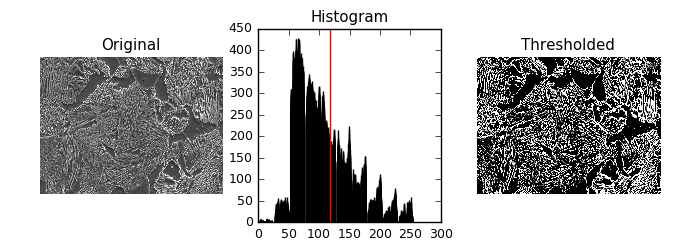

In [28]:


import matplotlib
import matplotlib.pyplot as plt

from skimage.data import camera
from skimage.filters import threshold_otsu


matplotlib.rcParams['font.size'] = 9

thresh = threshold_otsu(image)
binary = image > thresh

#fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(8, 2.5))
fig = plt.figure(figsize=(8, 2.5))
ax1 = plt.subplot(1, 3, 1, adjustable='box-forced')
ax2 = plt.subplot(1, 3, 2)
ax3 = plt.subplot(1, 3, 3, sharex=ax1, sharey=ax1, adjustable='box-forced')

ax1.imshow(image, cmap=plt.cm.gray)
ax1.set_title('Original')
ax1.axis('off')

ax2.hist(image)
ax2.set_title('Histogram')
ax2.axvline(thresh, color='r')

ax3.imshow(binary, cmap=plt.cm.gray)
ax3.set_title('Thresholded')
ax3.axis('off')

plt.show()


In [3]:
image = PIL.Image.open('data/1045_Steel_Nital-etch-01.tif')

In [4]:
image.size

(1280, 1024)

In [5]:
960 / 1024

0.9375

In [6]:
data['filename'][0]

'data/1045_Steel_Nital-etch-01.tif'

### Thresholding

http://scikit-image.org/docs/dev/auto_examples/plot_otsu.html